In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
from functools import partial

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from tqdm.auto import tqdm
from utils import PatchToDataframeTask, apply_lgbm_to_eopatch, plot_mask

from eolearn.core import ExtractBandsTask, FeatureType, RemoveFeatureTask, merge_eopatches
from eolearn.geometry import VectorToRasterTask
from eolearn.io import SentinelHubInputTask
from sentinelhub import DataCollection, UtmZoneSplitter

# Introduction

The AgriDataValue EO Data Capturing Toolbox uses Sentinel Hub capabilities to catalogue, store, access, and process satellite and drone imagery, and  indicators data.

Copernicus missions’ imagery (Sentinel-1 GRD, Sentinel-2 Level-1C/Level-2A, Sentinel-3 OLCI, Sentinel-5P) and other satellite imagery are accessible through Sentinel Hub. Additionally, EO derived data from Copernicus Land (CLMS) services datasets are also available. 

Sometimes the processing capabilities of Sentinel Hub alone are not enough and additional processing needs to be done. In such cases, [`sentinelhub-py`](https://sentinelhub-py.readthedocs.org) with the combination of [`eo-learn`](https://eo-learn.readthedocs.org) and [`eo-grow`](https://eo-grow.readthedocs.org) can be used to efficiently retrieve the data from Sentinel Hub and perform the processing off-line.

This is particularly true when working with complex workflows that require spatio-temporal context (i.e. deep learning convolutional models) and specialised tools. Even though the processing is performed offline - the results can be ingested back into Sentinel Hub through the BYOC API, so the final results are accessible in the same manner as all other data that was processed by Sentinel Hub directly. In the context of AgriDataValue this enables us to decouple the modelling and the inference of these models from the data source.

This notebook showcases how [`eo-learn`](https://eo-learn.readthedocs.org) can supplement the Sentinel Hub capabilities. In the following example, we will show how to combine ground truth data with satellite observations to create machine learning model capable of finding burned-up areas. 

# Data preparation

## Ground truth data

We will be using data from Institute for Nature Conservation and Forests that shows the polygons affected by wildfires in Portugal (https://geocatalogo.icnf.pt/catalogo_tema5.html). The data cover many years and a plethora of different causes of the fires, but in this case we have limited the dataset to 2019/2020 and fires happening in forests or agricultural areas. Prepared dataset is available as part of the example.

In [3]:
# read prepared vector layer, convert time
gdf = gpd.read_file("wildfires_GT_2019_2020_32629.gpkg")
gdf.start_date = pd.to_datetime(gdf.start_date)
gdf.end_date = pd.to_datetime(gdf.end_date)

# sort by burned area size
gdf.sort_values("area_ha", ascending=False, inplace=True)
gdf.reset_index(drop=True, inplace=True)

Let's see the largest burned area:

<Axes: >

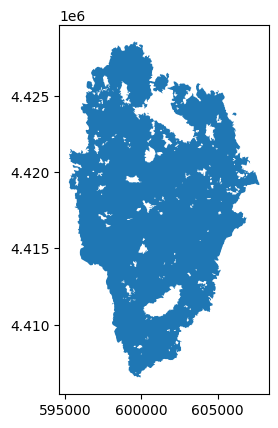

In [4]:
gdf.head(1).plot()

We can see that some of the burned-up areas are large, so we split each into a grid of tiles using large area utils from `sentinelhub-py`.

In [5]:
# assign the bbox splitter for each geometry
gdf["bbox_splitter"] = [UtmZoneSplitter([geom], gdf.crs, bbox_size=(3000, 3000)) for geom in tqdm(gdf.geometry)]

  0%|          | 0/1239 [00:00<?, ?it/s]

At the moment we will reduce the number of data by keeping only grid tiles that are more than 20% covered with burned area.

In [6]:
# go over all bboxes, calculate intersection with the vector layer for each one
meta_info = []
for idx in tqdm(gdf.index):
    row = gdf.iloc[idx]
    for jdx, bbox in enumerate(row.bbox_splitter.get_bbox_list()):
        meta_info.append(
            {
                "geo_idx": idx,
                "bbox_idx": jdx,
                "coverage": row.geometry.intersection(bbox.geometry).area / bbox.geometry.area,
            }
        )

meta_info = pd.DataFrame(meta_info)

# filter bboxes
sub_meta_info = meta_info.query("coverage > 0.2").reset_index(drop=True).copy()

  0%|          | 0/1239 [00:00<?, ?it/s]

## Satellite data

To get to know the data (and prepare the training data) we want to obtain the satellite imagery as well. We will be using `eo-learn` for that, with the following steps:
 * we download imagery with `SentinelHubInputTask`, allowing us to obtain all Sentinel-2 Level-2A bands, together with data mask (where data is available, particularly useful if we are at the border of a Sentinel-2 orbit) and cloud mask and probability from `s2cloudless` model.
 * we rasterize ground truth polygons, so we can work with both ground truth and satellite data

We will download two images for each wild-fire occurence: one image from around 16-days before the fire, and one from around 16-days after the fire. We will store all this data within `EOPatches`, the `eo-learn` data container.

In [7]:
# prepare the download task
input_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L2A,
    bands_feature=(FeatureType.DATA, "BANDS"),
    additional_data=[
        (FeatureType.MASK, "dataMask"),
        (FeatureType.DATA, "CLP"),
        (FeatureType.MASK, "CLM"),
    ],
    resolution=10,
    maxcc=0.7,
    time_difference=datetime.timedelta(hours=2),
    single_scene=True,
    mosaicking_order="leastCC",
    max_threads=8,
)

# prepare the rasterization task
v2r_partial = partial(
    VectorToRasterTask,
    raster_feature=(FeatureType.MASK_TIMELESS, "BURN_AREA"),
    raster_shape=(FeatureType.DATA, "BANDS"),
    no_data_value=0,
)

To showcase (and speed up the example), we'll run the pipeline on a small subsample of the data:

In [8]:
subsample = sub_meta_info.sample(5, random_state=42).copy()

# download before and after satellite imagery in a 14-day mosaic each
eopatch_list = []
for eopatch_id, (idx, meta_row) in tqdm(enumerate(subsample.iterrows()), total=len(subsample)):
    row = gdf.iloc[int(meta_row.geo_idx)]
    bbox = row.bbox_splitter.get_bbox_list()[int(meta_row.bbox_idx)]

    # download data
    days = 16
    eop_before = input_task(
        bbox=bbox,
        time_interval=(
            row.start_date - datetime.timedelta(days=days),
            row.start_date - datetime.timedelta(days=2),
        ),
    )
    eop_after = input_task(
        bbox=bbox,
        time_interval=(
            row.end_date + datetime.timedelta(days=2),
            row.end_date + datetime.timedelta(days=days),
        ),
    )

    # rasterize
    eop_before = v2r_partial(vector_input=gdf.iloc[[int(meta_row.geo_idx)]], values=1)(eop_before)
    eop_after = v2r_partial(vector_input=gdf.iloc[[int(meta_row.geo_idx)]], values=1)(eop_after)

    # merge
    eop_before.meta_info, eop_after.meta_info = {}, {}
    eop = merge_eopatches(eop_before, eop_after)

    bands = [band.name for band in DataCollection.SENTINEL2_L2A.bands]
    for idx, band in enumerate(bands):
        task = ExtractBandsTask((FeatureType.DATA, "BANDS"), (FeatureType.DATA, band), [idx])
        eop = task(eop)

    eop = RemoveFeatureTask((FeatureType.DATA, "BANDS"))(eop)
    eopatch_list.append(eop)

    eop.save(f"./eopatches/eopatch_{eopatch_id}")

  0%|          | 0/5 [00:00<?, ?it/s]

## Visualize GT and Satellite data

We can now visualize the data we have put into `EOPatches`:

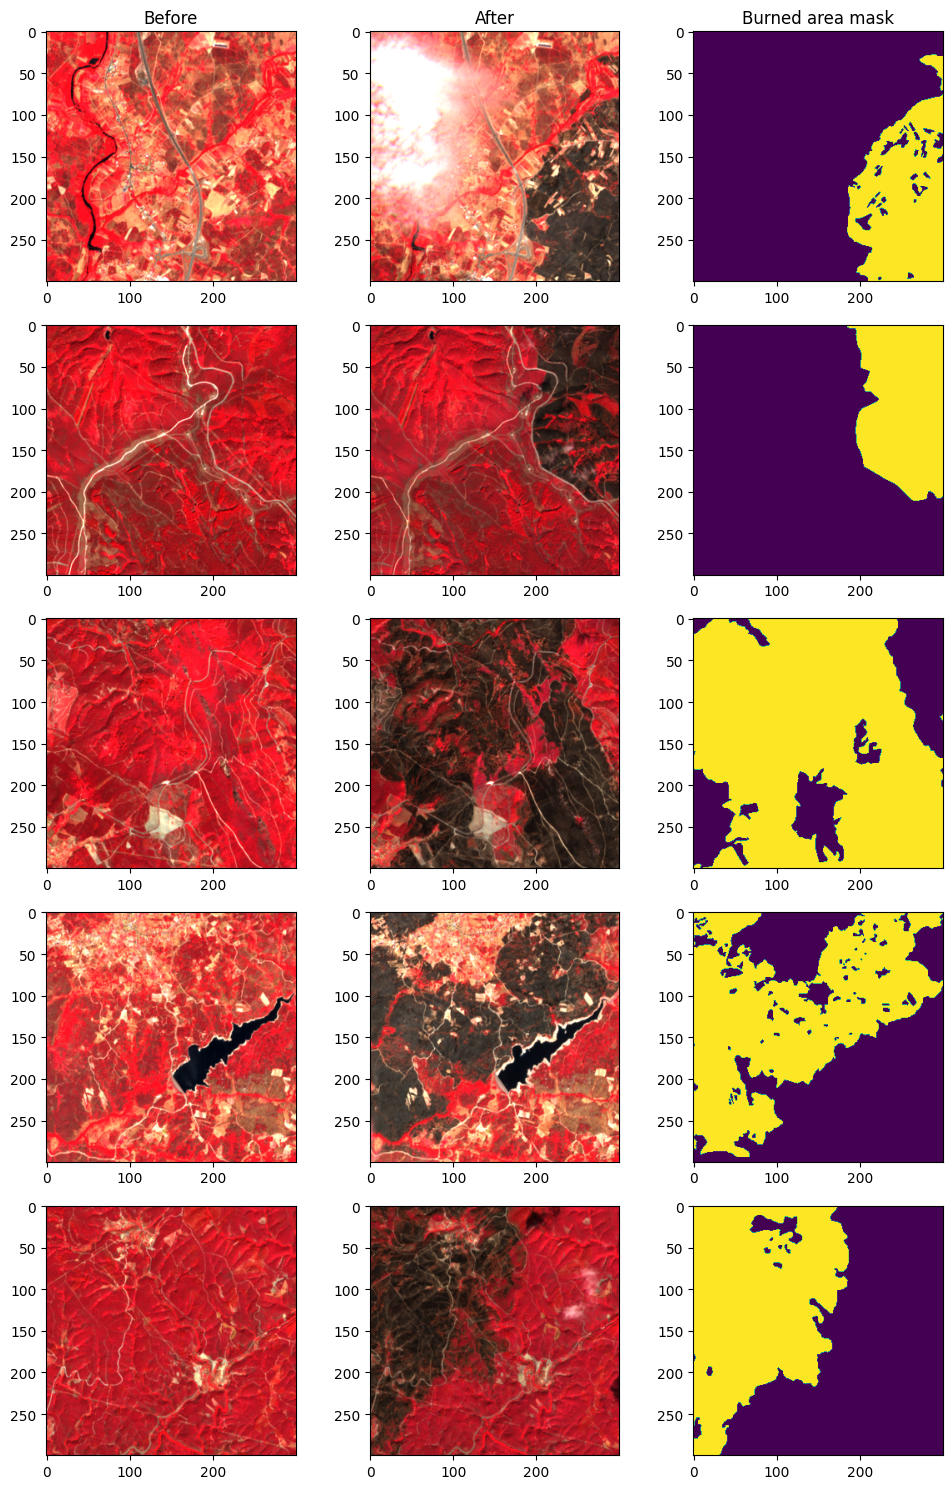

In [9]:
fig, axs = plt.subplots(ncols=3, nrows=len(eopatch_list), figsize=(10, 15))

axs[0][0].set_title("Before")
axs[0][1].set_title("After")
axs[0][2].set_title("Burned area mask")

for idx, eop in enumerate(eopatch_list):
    # R, G, B -> [R,G,B]
    rgb = np.stack(
        (eop.data["B08"][..., 0], eop.data["B04"][..., 0], eop.data["B03"][..., 0]),
        axis=-1,
    )
    rgb = np.clip(rgb * 3.5, 0, 1)

    axs[idx][0].imshow(rgb[0])
    axs[idx][1].imshow(rgb[1])

    mask = eop.mask_timeless["BURN_AREA"]
    axs[idx][2].imshow(mask, vmin=0, vmax=1)

plt.tight_layout()

## Preparing training data

In this section we will convert the data we have downloaded from `EOPatch` format into a pandas dataframe, which we can directly use with a number of ML frameworks to train a model. 

We will tag each value with BURN_AREA value 0 if the pixel comes from the observation before the fire, and with 1 if the observation is after the fire. Each Sentinel-2 band value will be stored in its own column.

In [10]:
from eolearn.core import EOPatch

eopatch_list = [EOPatch.load(f"eopatches/eopatch_{idx}") for idx in range(5)]

In [11]:
eopatch_list[0]

EOPatch(
  bbox=BBox(((630000.0, 4629000.0), (633000.0, 4632000.0)), crs=CRS('32629'))
  timestamps=[datetime.datetime(2020, 7, 14, 0, 0), datetime.datetime(2020, 8, 2, 0, 0)]
  mask_timeless={
    BURN_AREA: numpy.ndarray(shape=(300, 300, 1), dtype=uint8)
  }
  data={
    B01: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B02: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B03: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B04: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B05: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B06: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B07: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B08: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B09: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B11: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B12: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B8A: numpy.ndarray(shape=(2, 300, 300, 1), d

In [12]:
# task to convert eopatch to a dataframe
patch2df_task = PatchToDataframeTask(
    output_feature=(FeatureType.META_INFO, "DF"),
    shape_info_feature=(FeatureType.META_INFO, "SHAPE"),
    mask_feature=None,
)

df_list = []
for idx, eop in tqdm(enumerate(eopatch_list)):
    temp_df = patch2df_task(eop.copy()).meta_info["DF"]
    temp_df.loc[
        (temp_df.BURN_AREA == 1) & (temp_df.TIMESTAMP == temp_df.TIMESTAMP.min()),
        "BURN_AREA",
    ] = 0
    temp_df["EOPATCH"] = f"eopatch_{idx}"
    df_list.append(temp_df)

df = pd.concat(df_list).copy()

df.query("dataMask", inplace=True)
df.eval("CLP = CLP/255", inplace=True)

df.query("CLP < 0.4 and CLM == 0", inplace=True)
df.drop(columns=["CLP", "CLM", "dataMask", "ID_X", "ID_Y"], inplace=True)
df.reset_index(drop=True, inplace=True)

columns = [
    "EOPATCH",
    "TIMESTAMP",
    "B01",
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B09",
    "B11",
    "B12",
    "BURN_AREA",
]
df = df[columns]

df.head()

0it [00:00, ?it/s]

,EOPATCH,TIMESTAMP,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,BURN_AREA
0,eopatch_0,2020-07-14,0.0388,0.0588,0.0952,0.1242,0.1892,0.2841,0.3297,0.3516,0.3839,0.3693,0.3522,0.2002,0
1,eopatch_0,2020-07-14,0.0388,0.0658,0.1042,0.1300,0.1892,0.2841,0.3297,0.3630,0.3839,0.3693,0.3522,0.2002,0
2,eopatch_0,2020-07-14,0.0388,0.0633,0.0992,0.1204,0.1700,0.2749,0.3178,0.3684,0.3714,0.3693,0.3262,0.1825,0
3,eopatch_0,2020-07-14,0.0388,0.0483,0.0855,0.0951,0.1700,0.2749,0.3178,0.3575,0.3714,0.3693,0.3262,0.1825,0
4,eopatch_0,2020-07-14,0.0388,0.0383,0.0728,0.0733,0.1399,0.2875,0.3427,0.3365,0.3717,0.3693,0.2927,0.1551,0


We can now store samples into the training dataset for future reference.

In [13]:
n_samples = 100000
class_fractions = {0: 0.5, 1: 0.5}

samples = pd.concat(
    [df.query(f"BURN_AREA == {c}").sample(n=int(n_samples * f), random_state=42) for c, f in class_fractions.items()]
).copy()
samples.sample(frac=1, random_state=42).reset_index(drop=True, inplace=True)

# Model training

We will use all the bands as input features for the model, and burn area as the label.

In [14]:
MODEL_FEATURES = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B09", "B11", "B12", "B8A"]
LABEL = "BURN_AREA"

In [15]:
train = samples.sample(frac=0.8, random_state=42)
test = samples[~samples.index.isin(train.index)]

In [16]:
clf = LGBMClassifier()

clf.fit(train[MODEL_FEATURES], train[LABEL], feature_name=MODEL_FEATURES);

### Model visualization

Now we can visualize our results with respect to ground truth over eopatches we have downloaded:

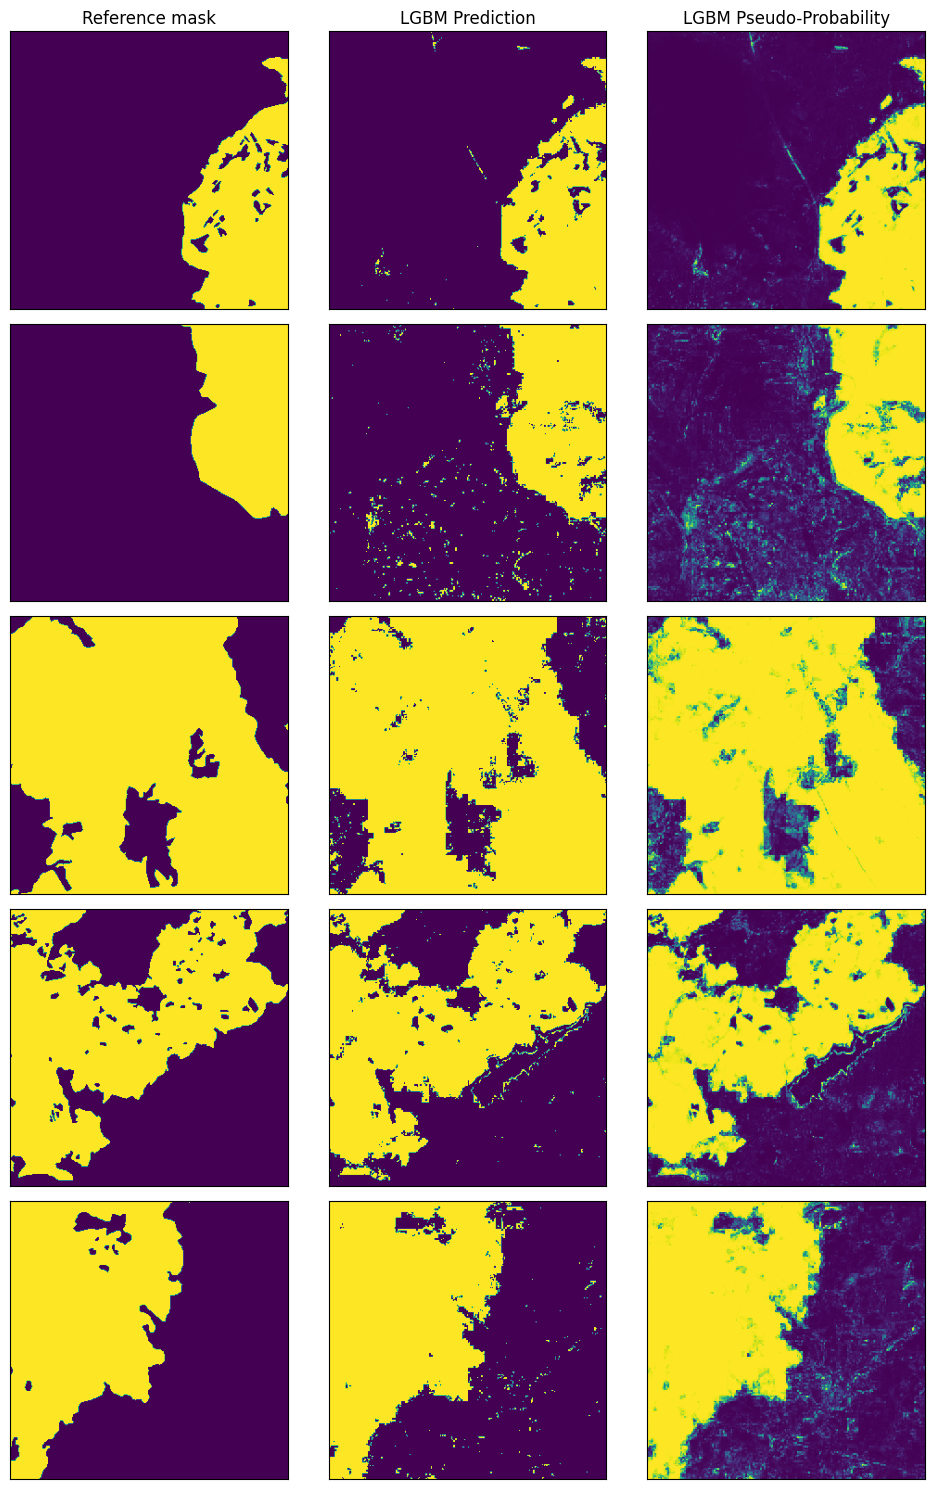

In [17]:
fig, axs = plt.subplots(ncols=3, nrows=len(eopatch_list), figsize=(10, 15))

for idx, eop in enumerate(eopatch_list):
    eop = apply_lgbm_to_eopatch(
        eopatch=eop,
        timestamp_index=1,
        classifier=clf,
        output_mask_name="LGBM",
    )

    plot_mask(eop.mask_timeless["BURN_AREA"], ax=axs[idx][0])
    plot_mask(eop.mask_timeless["LGBM"], ax=axs[idx][1])
    plot_mask(eop.data_timeless["LGBM_PROBA"], ax=axs[idx][2])

axs[0][0].set_title("Reference mask")
axs[0][1].set_title("LGBM Prediction")
axs[0][2].set_title("LGBM Pseudo-Probability")

plt.tight_layout()